Importing Necessary Libraries and Modules

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
import shutil
import time
from sklearn.metrics import classification_report

2024-05-26 07:48:08.935142: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 07:48:08.935245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 07:48:09.073218: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Dataset

In [4]:
train_df = pd.read_csv("/kaggle/input/butterfly-image-classification/Training_set.csv")
train_folder = ("/kaggle/input/butterfly-image-classification/train/")
test_df = pd.read_csv("/kaggle/input/butterfly-image-classification/Testing_set.csv")
test_folder = ("/kaggle/input/butterfly-image-classification/test/")

Output paths

In [5]:
result_path = f"/kaggle/working/run/"
os.makedirs(result_path, exist_ok=True)

checkpoint_path = os.path.join(result_path, "best_model.keras")
loss_image_path = os.path.join(result_path, 'validation loss.png')
acc_image_path = os.path.join(result_path, 'validation accuracy.png')
confusion_image_path = os.path.join(result_path, 'confusion matrix.png')

In [6]:
train_df.head()


,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6499 non-null   object
 1   label     6499 non-null   object
dtypes: object(2)
memory usage: 101.7+ KB


PLOTTTING THE DISTRIBUTION OF BUTTERFLIES

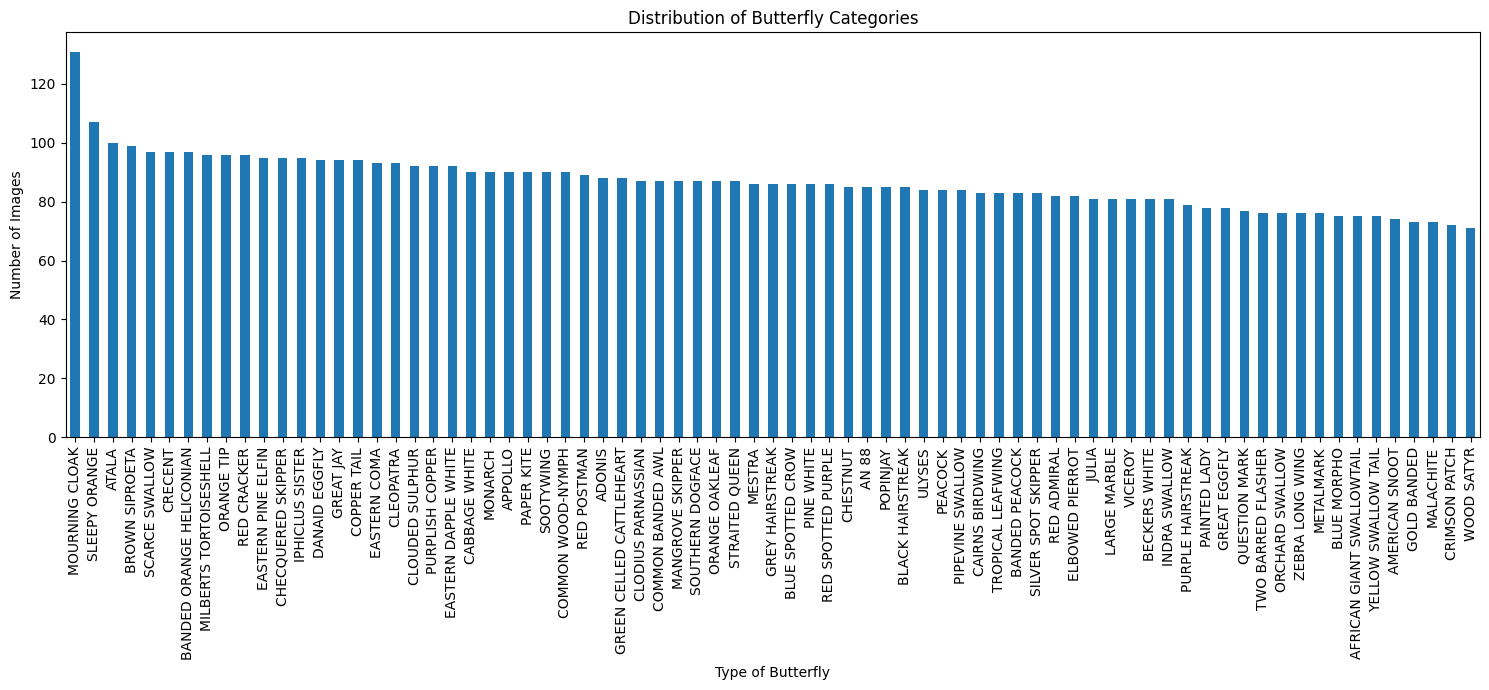

In [8]:
plt.figure(figsize=(15, 7))
train_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Butterfly Categories')
plt.xlabel('Type of Butterfly')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

HYPERPARAMETERS 

In [19]:
image_size = (150,150)
batch_size = 32
epochs = 50
learning_rate = 0.0001

class_name = list(set(train_df['label']))
print(class_name)

['PAINTED LADY', 'STRAITED QUEEN', 'WOOD SATYR', 'DANAID EGGFLY', 'CRIMSON PATCH', 'MOURNING CLOAK', 'ULYSES', 'GREAT EGGFLY', 'TWO BARRED FLASHER', 'POPINJAY', 'MONARCH', 'RED SPOTTED PURPLE', 'CHESTNUT', 'YELLOW SWALLOW TAIL', 'ORANGE OAKLEAF', 'SOUTHERN DOGFACE', 'CHECQUERED SKIPPER', 'RED POSTMAN', 'MANGROVE SKIPPER', 'AFRICAN GIANT SWALLOWTAIL', 'AN 88', 'SOOTYWING', 'PAPER KITE', 'VICEROY', 'SLEEPY ORANGE', 'PIPEVINE SWALLOW', 'MILBERTS TORTOISESHELL', 'CLEOPATRA', 'JULIA', 'ORCHARD SWALLOW', 'MALACHITE', 'EASTERN COMA', 'TROPICAL LEAFWING', 'PEACOCK', 'AMERICAN SNOOT', 'SILVER SPOT SKIPPER', 'COMMON BANDED AWL', 'IPHICLUS SISTER', 'INDRA SWALLOW', 'CRECENT', 'ATALA', 'EASTERN DAPPLE WHITE', 'ADONIS', 'LARGE MARBLE', 'EASTERN PINE ELFIN', 'APPOLLO', 'METALMARK', 'RED CRACKER', 'COPPER TAIL', 'ELBOWED PIERROT', 'SCARCE SWALLOW', 'PURPLE HAIRSTREAK', 'BLACK HAIRSTREAK', 'BECKERS WHITE', 'GREAT JAY', 'BROWN SIPROETA', 'CAIRNS BIRDWING', 'RED ADMIRAL', 'ORANGE TIP', 'GREEN CELLED CAT

In [10]:
features = []
labels = []

for image in tqdm(os.listdir(train_folder), desc="Preprocess Image") :
    label_name = train_df.loc[train_df['filename'] == image, 'label'].values[0]
    label = class_name.index(label_name)
    image_read = cv2.imread(os.path.join(train_folder, image))
    image_resized = cv2.resize(image_read, image_size)
    image_normalized = image_resized / 255.0
    features.append(image_normalized)
    labels.append(label)

Preprocess Image: 100%|██████████| 6499/6499 [01:00<00:00, 107.76it/s]


In [11]:
print(len(features))
print(len(labels))

features = np.asarray(features)
labels = np.asarray(labels)

6499
6499


SPLITTING THE DATA

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

In [13]:
del features
del labels

BASE MODEL

In [20]:
base_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(image_size[0], image_size[1], 3),
)

num_layers_to_train = int(np.ceil(0.2 * len(base_model.layers)))

for layer in base_model.layers[:num_layers_to_train] :
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
predictions = Dense(75, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 36,714,443 (140.05 MB)

 Trainable params: 36,451,659 (139.05 MB)

 Non-trainable params: 262,784 (1.00 MB)

TRAINING 


In [21]:
model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

start_time = time.time()

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data = (X_valid,y_valid),
    callbacks=[model_checkpoint, early_stopping],
    batch_size = batch_size,
)

end_time = time.time()

Epoch 1/50
  1/143 ━━━━━━━━━━━━━━━━━━━━ 1:38:07 41s/step - accuracy: 0.0000e+00 - loss: 10.7243

W0000 00:00:1716710637.204728      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.2056 - loss: 8.5213

W0000 00:00:1716710671.474598      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716710675.865298      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716710679.025683      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 308ms/step - accuracy: 0.2067 - loss: 8.5128 - val_accuracy: 0.0513 - val_loss: 8.2929
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 165ms/step - accuracy: 0.7791 - loss: 4.5795 - val_accuracy: 0.3221 - val_loss: 6.1613
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 166ms/step - accuracy: 0.9386 - loss: 3.2421 - val_accuracy: 0.5631 - val_loss: 4.3713
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 0.9546 - loss: 2.6241 - val_accuracy: 0.7559 - val_loss: 3.1582
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 0.9894 - loss: 2.0773 - val_accuracy: 0.7559 - val_loss: 2.7690
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 164ms/step - accuracy: 0.9966 - loss: 1.6992 - val_accuracy: 0.7938 - val_loss: 2.3142
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 164ms/step - accuracy: 0.9980 - loss: 1.4007 - val_accuracy: 0.7949 - val_loss: 2.0777
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.9913 - loss: 1.1964 - val

In [22]:
print("Training Time", end_time - start_time)

Training Time 1018.0300178527832


PLOTTING Training Loss vs Validation Loss

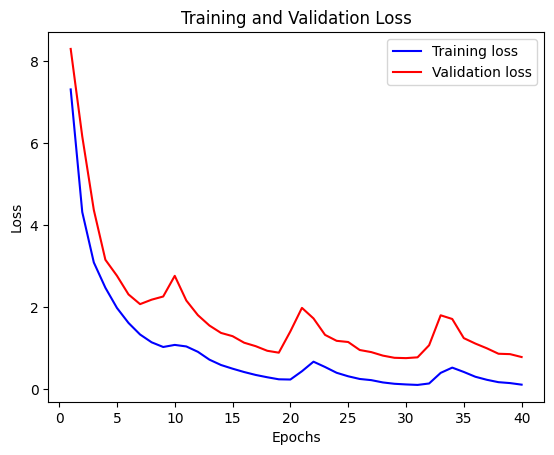

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(loss_image_path)
plt.show()

PLOTTING TRAINING ACCURACY VS VALIDATION ACCURACY

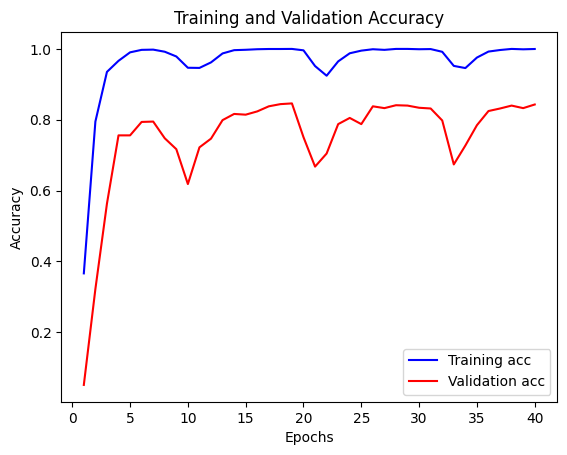

In [24]:
acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(acc_image_path)
plt.show()

OUTPUT

In [25]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)

classification_rep = classification_report(y_test, y_pred, target_names=class_name, digits=4)
print("Classification Report:\n", classification_rep)

classification_file = 'classification_report.txt'
with open(classification_file, 'w') as file:
    file.write(classification_rep)

 4/31 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

W0000 00:00:1716711862.498190      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step
Classification Report:
                            precision    recall  f1-score   support

             PAINTED LADY     0.7000    1.0000    0.8235         7
           STRAITED QUEEN     0.8889    0.8000    0.8421        10
               WOOD SATYR     0.8750    0.7778    0.8235         9
            DANAID EGGFLY     0.8750    0.7778    0.8235        18
            CRIMSON PATCH     0.9231    0.9231    0.9231        13
           MOURNING CLOAK     1.0000    0.8889    0.9412        27
                   ULYSES     0.8462    0.9167    0.8800        12
             GREAT EGGFLY     0.7000    0.7000    0.7000        10
       TWO BARRED FLASHER     0.8000    0.7273    0.7619        11
                 POPINJAY     1.0000    0.9167    0.9565        12
                  MONARCH     0.7500    1.0000    0.8571        12
       RED SPOTTED PURPLE     0.8571    0.8571    0.8571         7
                 CHESTNUT     0.9375    1.0000    0.9677       

W0000 00:00:1716711867.347738      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
